In [45]:
import torch
import torch.nn as nn
import random
from collections import deque

# torch.manual_seed(33)
# random.seed(33)

# Configuration
NVTXS = 8
MAXDIST = NVTXS + 1
AVGDEG = 2
SEQLEN = NVTXS + 1
HIDDENDIM = 4 * NVTXS + 2
START_REACH = NVTXS + 1
START_OUT = 2 * NVTXS + 1
START_SELF = 3 * NVTXS + 1
SRC_FLAG_IDX = START_SELF
ANS_FLAG_IDX = 0
NOTANS_FLAG_IDX = -1

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def random_graph(device):
    """Generate a random graph tensor."""
    data = torch.zeros((SEQLEN, HIDDENDIM), device=device)
    
    # Mark self vertices
    for i in range(1, NVTXS + 1):
        data[i, START_SELF - 1 + i] = 1

    # Create adjacency list
    adj_list = [set() for _ in range(SEQLEN)]
    indices = [random.randint(1, NVTXS) for _ in range(AVGDEG * NVTXS)]
    
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            # Bidirectional connections
            data[v, u] = 1
            data[u, v] = 1
            data[v, NVTXS + u] = 1
            data[u, NVTXS + v] = 1
            adj_list[u].add(v)
            adj_list[v].add(u)

    # Set flags
    data[0, ANS_FLAG_IDX] = 1
    data[1:, NOTANS_FLAG_IDX] = 1
    data[0, START_REACH:START_REACH + NVTXS] = 1
    return data, adj_list

def SSSP(G):
    """Single Source Shortest Path algorithm."""
    dist = [MAXDIST for _ in G]
    dist[1] = 0
    frontier = deque([1])
    while frontier:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAXDIST:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == 2:
                    return dist[2]
    return MAXDIST

def mkbatch(size):
    """Create a batch of graph data."""
    graphs = []
    distances = []

    for _ in range(size):
        data, adj_list = random_graph(device)
        dist = SSSP(adj_list)
        graphs.append(data)
        distances.append(dist)

    data = torch.stack(graphs)
    labels = torch.tensor(distances, dtype=torch.float32, device=device)
    return data, labels
    
BIG,SUPABIG,MED,CURSE = 12,30,7,5

class SillyTransformer(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

        with torch.no_grad():
            # Initialize weight parameters with specific configurations
            self.mostKs = nn.ParameterList()
            self.mostQs = nn.ParameterList()
            self.mostVs = nn.ParameterList()
            for head in range(1, NVTXS + 1):
                Q = nn.Parameter(torch.zeros((2, HIDDENDIM), device=device))
                Q[0, START_REACH - 1 + head] = SUPABIG
                Q[1, NOTANS_FLAG_IDX] = 1
                K = nn.Parameter(torch.zeros((2, HIDDENDIM), device=device))
                K[0, head] = 1
                K[1, ANS_FLAG_IDX] = BIG

                V = nn.Parameter(torch.zeros((NVTXS, HIDDENDIM), device=device))
                for i in range(NVTXS):
                    V[i, START_SELF + i] = 1

                self.mostKs.append(K)
                self.mostQs.append(Q)
                self.mostVs.append(V)
            self.weirdKs = nn.ParameterList()
            self.weirdQs = nn.ParameterList()
            self.weirdVs = nn.ParameterList()
            for layer in range(NVTXS):
                K = nn.Parameter(torch.zeros((3, HIDDENDIM), device=device))
                K[0, NOTANS_FLAG_IDX] = -BIG
                K[0, SRC_FLAG_IDX] = BIG+SUPABIG
                K[1, NOTANS_FLAG_IDX] = -SUPABIG
                K[1, NVTXS + 2] = BIG+SUPABIG
                K[1, ANS_FLAG_IDX] = -BIG-SUPABIG
                K[2, ANS_FLAG_IDX] = MED

                Q = nn.Parameter(torch.zeros((3, HIDDENDIM), device=device))
                Q[:, ANS_FLAG_IDX] = 1

                V = nn.Parameter(torch.zeros((NVTXS, HIDDENDIM), device=device))
                V[layer, SRC_FLAG_IDX] = 1

                self.weirdKs.append(K)
                self.weirdQs.append(Q)
                self.weirdVs.append(V)

    def forward(self, src):
        for layer in range(NVTXS):
            allKs = [self.weirdKs[layer]] + [x for x in self.mostKs]
            allQs = [self.weirdQs[layer]] + [x for x in self.mostQs]
            allVs = [self.weirdVs[layer]] + [x for x in self.mostVs]
            head_outputs = []
            
            for (K, Q, V) in zip(allKs, allQs, allVs):
                ksrc = torch.matmul(src, K.unsqueeze(0).transpose(-2, -1))
                qsrc = torch.matmul(src, Q.unsqueeze(0).transpose(-2, -1))
                vsrc = torch.matmul(src, V.unsqueeze(0).transpose(-2, -1))

                scores = torch.matmul(qsrc, ksrc.transpose(-2, -1))
                attention_weights = torch.softmax(scores, dim=-1)
                head_output = torch.matmul(attention_weights, vsrc)
                head_outputs.append(head_output)

            new_reaches = sum(head_outputs[1:])
            BSZ = new_reaches.shape[0]

            nodelta_nbrs = torch.zeros((BSZ, SEQLEN, NVTXS + 1), device=self.device)
            morepadlol = torch.zeros((BSZ, SEQLEN, 1 + NVTXS), device=self.device)

            src = src + torch.cat((nodelta_nbrs, new_reaches, head_outputs[0], morepadlol), dim=2)
            src[:, :, START_REACH:START_REACH + NVTXS] = 2 * torch.sigmoid(src[:, :, START_REACH:START_REACH + NVTXS] * CURSE) - 1

        canreach = src[:, 0, START_OUT:START_OUT + NVTXS]
        final_output = 1 + torch.sum(1 - canreach, dim=1)
        return final_output

model = SillyTransformer(device).to(device)
params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {params}")

def destroy_rand_weights(model):
    weight_lists = [model.mostKs, model.mostQs, model.mostVs, 
                    model.weirdKs, model.weirdQs, model.weirdVs]
    random_list = random.choice(weight_lists)
    random_matrix = random.choice(random_list)
    random_matrix.data = torch.randn_like(random_matrix)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = nn.MSELoss()

Total number of parameters: 7072


In [47]:
destroy_rand_weights(model)
num_epochs = 10000
batch_size = 1<<9
train_err = []
for epoch in range(num_epochs):
    model.train()
    data, labels = mkbatch(batch_size)
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_err.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [0/10000], Loss: 0.4030
Epoch [10/10000], Loss: 0.3534
Epoch [20/10000], Loss: 0.3482
Epoch [30/10000], Loss: 0.3803
Epoch [40/10000], Loss: 0.3565
Epoch [50/10000], Loss: 0.3746
Epoch [60/10000], Loss: 0.3738
Epoch [70/10000], Loss: 0.3184
Epoch [80/10000], Loss: 0.3618
Epoch [90/10000], Loss: 0.3509
Epoch [100/10000], Loss: 0.3325
Epoch [110/10000], Loss: 0.3196
Epoch [120/10000], Loss: 0.3198
Epoch [130/10000], Loss: 0.3047
Epoch [140/10000], Loss: 0.3318
Epoch [150/10000], Loss: 0.2962
Epoch [160/10000], Loss: 0.3227
Epoch [170/10000], Loss: 0.3037
Epoch [180/10000], Loss: 0.3056
Epoch [190/10000], Loss: 0.2926
Epoch [200/10000], Loss: 0.2875
Epoch [210/10000], Loss: 0.2778
Epoch [220/10000], Loss: 0.2771
Epoch [230/10000], Loss: 0.2859
Epoch [240/10000], Loss: 0.2520
Epoch [250/10000], Loss: 0.2974
Epoch [260/10000], Loss: 0.2615
Epoch [270/10000], Loss: 0.2589
Epoch [280/10000], Loss: 0.2376
Epoch [290/10000], Loss: 0.2455
Epoch [300/10000], Loss: 0.2594
Epoch [310/10000], 

KeyboardInterrupt: 

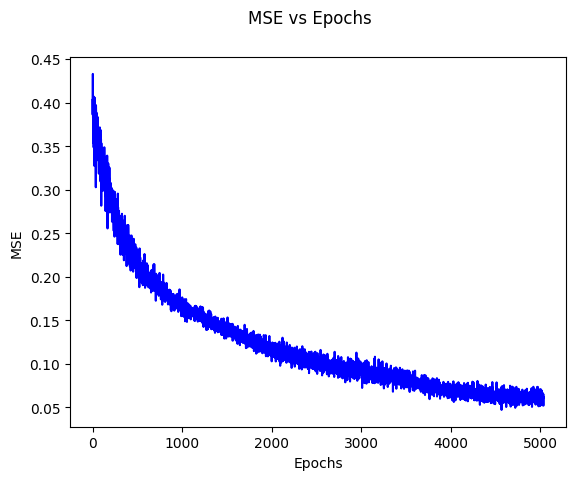

In [48]:
plt.suptitle('MSE vs Epochs')
plt.plot(train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

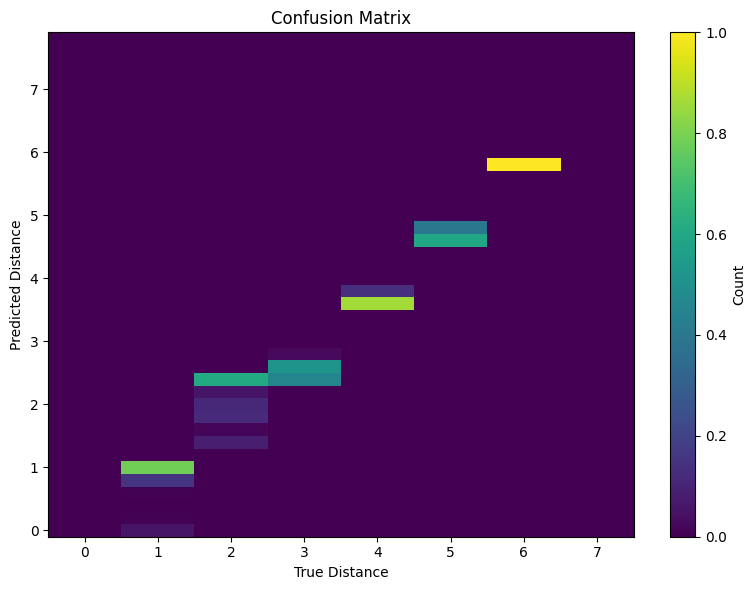

In [52]:
import numpy as np
import matplotlib.pyplot as plt
batch_src, batch_labels = map(lambda x: x.to(device), mkbatch(1<<10))
model.eval()
with torch.no_grad():
    output = model(batch_src)

# Flatten the arrays to 1D
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()

# Define the number of vertices and number of bins per dimension
bins_y = 5 * NVTXS  # 10 * nvtxs for y-bin size

# Initialize the 2D array (matrix) to store the counts
count_matrix = np.zeros((NVTXS, bins_y), dtype=float)

# Process the data: Map x to rows and floor(y*10) to columns
for xi, yi in zip(x, y):
    row = int(xi)  # Use integer value of x for row index
    col = int(np.floor(yi * 5))  # Map y values to column by flooring and scaling by 10
    if 0 <= row < NVTXS and 0 <= col < bins_y:  # Ensure valid indices
        count_matrix[row, col] += 1

# Transpose the matrix
count_matrix = count_matrix.T

# column_sums = count_matrix.sum(axis=0)  # Sum of each column
# count_matrix = np.divide(count_matrix, column_sums, where=column_sums >.001)  # Avoid division by zero
for i in range(count_matrix.shape[1]):
    if np.sum(count_matrix[:,i])>1:
        count_matrix[:,i] = count_matrix[:,i] / np.sum(count_matrix[:,i])
    
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(count_matrix, cmap='viridis', origin='lower', interpolation='nearest', aspect='auto')

# Set the labels and title
plt.ylabel('Predicted Distance')
plt.yticks([i*5 for i in range(8)], [i for i in range(8)])
plt.xlabel('True Distance')
plt.title('Confusion Matrix')

# Add a colorbar for reference
plt.colorbar(label='Count')

# Show the plot
plt.tight_layout()
plt.show()